In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

>Load smFISH data

In [2]:
cellplot = np.load('black_cellplot.npy')
seg = np.load('refine_seg.npy')

>Change cellplot to white

In [ ]:
temp = cellplot[:,:,0] + cellplot[:,:,1] + cellplot[:,:,2]
cellplot[temp==0] = [255,255,255]

In [ ]:
width, height = 1200, 1200

In [ ]:
padded_width = int(seg.shape[0]//width+1)*width
padded_height = int(seg.shape[1]//height+1)*height

In [6]:
# padding to 15600*15600
padded_seg = np.pad(seg, pad_width=((0, padded_width-15143),(0, padded_height-15097)), mode='constant',constant_values=0).astype('int16')
padded_cellplot = np.pad(cellplot, pad_width=((0, padded_width-15143),(0, padded_height-15097),(0,0)), mode='constant',constant_values=255).astype('int16')

In [7]:
color_map = {4:  np.array([ 23, 114, 140]),
             0:  np.array([197, 229, 189]),
             5:  np.array([170,  95, 172]),
             6:  np.array([116, 142, 191]),
             1:  np.array([  0, 200, 251]),
             3:  np.array([180,  56,  38]),
             2:  np.array([240,  31,  26]),
             7:  np.array([254, 209,   0]),
             10: np.array([  0, 176,  85]),
             17: np.array([174, 149, 140]),
             13: np.array([252, 145,  42]),
             11: np.array([206, 154, 104]),
             14: np.array([253, 157, 198]),
             15: np.array([238, 220, 228]),
             16: np.array([255, 179, 161]),
             12: np.array([255, 217, 206]),
             9:  np.array([220,  20,  60]),
             8:  np.array([ 65, 105, 225])}

In [8]:
def cropping(img, curr_x, curr_y, direct, 
             crop_width=width, crop_height=height):
    if curr_x not in range(0, img.shape[0]-width+1) or curr_y not in range(0, img.shape[1]-height+1):
        raise ValueError('Wrong coordinate.')
    if direct[0] == 'u':
        temp = img[curr_x:curr_x+crop_width,:,:]
    elif direct[0] == 'd': 
        temp = img[curr_x-crop_width:curr_x,:,:]
    else:
        raise ValueError("First letter must be 'r' or 'l'.")
    if direct[1] == 'r':
        temp = temp[:,curr_y:curr_y+crop_height,:]
    elif direct[1] == 'l': 
        temp = temp[:,curr_y-crop_height:curr_y,:]
    else:
        raise ValueError("Second letter must be 'u' or 'd'.")
    return temp

In [9]:
def color_to_cell(color):
    return [k for k,v in color_map.items() if (v==color).all()]

In [10]:
from skimage import measure
def count_cell(crop_seg, crop_cellplot):
    properties = measure.regionprops(crop_seg)
    count_list = np.full((len(color_map),), 0) # 按1-14的编号顺序
    total_cell_count = len(properties)
    for prop in properties:
        coords = prop.centroid
        label =  color_to_cell(crop_cellplot[int(coords[0]),int(coords[1])])
        if label!=0 and label!=[]:
            count_list[label[0]-1] += 1
    return count_list, total_cell_count

In [11]:
class null_box:
    def __init__(self):
        #print('This is a null box.')
        pass
    
    def get_box_name(self):
        return 'null'

In [12]:
class cellplot_box:
    def __init__(self, seg_nuclei_img, cellplot_img, x_coord, y_coord):
        self.seg_img = seg_nuclei_img
        self.cellplot_img = cellplot_img
        self.x = x_coord
        self.y = y_coord
        self.cropped_seg = cropping(self.seg_img, 
                                    self.x, self.y, direct='ur')
        self.cropped_cellplot = cropping(self.cellplot_img, 
                                         self.x, self.y, direct='ur')
        
    def get_raw_cell_count(self):
        self.raw_count_list, self.total_cell_num = count_cell(self.cropped_seg, 
                                                          self.cropped_cellplot)
        return self.raw_count_list
    
    def get_normed_cell_count(self):
        self.normed_count_list, self.total_cell_num = count_cell(self.cropped_seg, 
                                                          self.cropped_cellplot)
        if self.total_cell_num!=0:
            self.normed_count_list = self.normed_count_list / self.total_cell_num
        return self.normed_count_list
    
    def get_box_name(self):
        return 'box_{}_{}'.format(int(self.x/width), int(self.y/height))
    
    def get_adjacent_box(self, direction):
        if direction not in ['u','d','r','l']:
            raise ValueError("direction must be 'u','d','r', or 'l'")
        
        try:
            if direction == 'u':
                return self.__class__(self.seg_img, 
                                      self.cellplot_img, 
                                      self.x+width, 
                                      self.y)
            elif direction == 'd':
                return self.__class__(self.seg_img, 
                                      self.cellplot_img, 
                                      self.x-width, 
                                      self.y)
            elif direction == 'r':
                return self.__class__(self.seg_img, 
                                      self.cellplot_img, 
                                      self.x, 
                                      self.y+height)
            else:
                return self.__class__(self.seg_img, 
                                      self.cellplot_img, 
                                      self.x, 
                                      self.y-height)
        except:
            #print('direction is ' + direction)
            return null_box()

In [13]:
# total count of boxes
box_count = int(padded_seg.shape[0]/width*padded_seg.shape[1]/height)

In [14]:
raw_count_matrix = np.empty((box_count,len(color_map)))
normed_count_matrix = np.empty((box_count,len(color_map)))
box_id = list()

In [15]:
padded_seg = np.squeeze(padded_seg)
padded_seg = np.expand_dims(padded_seg, -1)
padded_seg.shape

(15600, 15600, 1)

>Cut picture

In [16]:
import sys
loop_count = 0
for curr_x in np.arange(0, padded_seg.shape[0], width):
    for curr_y in np.arange(0, padded_seg.shape[1], height):
        box = cellplot_box(padded_seg, 
                           padded_cellplot,
                           int(curr_x), 
                           int(curr_y))
        raw_count_matrix[loop_count] = box.get_raw_cell_count()
        normed_count_matrix[loop_count] = box.get_normed_cell_count()
        box_id.append(box.get_box_name())
        sys.stdout.write('\r' + str(loop_count))
        sys.stdout.flush()
        loop_count += 1

168

In [18]:
# to dataframe
df_raw = pd.DataFrame(raw_count_matrix, columns=[str(i) for i in range(1,19)], index=box_id)
df_norm = pd.DataFrame(normed_count_matrix, columns=[str(i) for i in range(1,19)], index=box_id)

In [19]:
#df_raw.to_csv('./box_celltype_raw_count_matrix.csv', index=False)
#df_norm.to_csv('./box_celltype_normed_count_matrix.csv', index=False)
df_raw = pd.read_csv('./box_celltype_raw_count_matrix.csv')
df_norm = pd.read_csv('./box_celltype_normed_count_matrix.csv')

>Clustering the windows-cell type proportion matrix

In [20]:
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [21]:
adata = sc.read_csv('./box_celltype_normed_count_matrix.csv')
adata = adata[1:]

In [23]:
#!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

In [24]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:13)


In [25]:
sc.tl.leiden(adata, resolution=0.15)

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [26]:
leiden_anno = adata.obs['leiden'].tolist()

In [27]:
meta_data = df_norm
meta_data['leiden_anno'] = leiden_anno

In [28]:
# change to white background
white = np.ndarray(shape=padded_cellplot.shape)
temp = padded_cellplot[:,:,0] + padded_cellplot[:,:,1] + padded_cellplot[:,:,2]
white[temp==0] = [255,255,255]

In [29]:
cluster_result = np.copy(white)

In [30]:
import sys
loop_count = 0
for curr_x in np.arange(0, padded_seg.shape[0], width):
    for curr_y in np.arange(0, padded_seg.shape[1], height):
        if leiden_anno[loop_count] == '0':
            cluster_result[curr_x:curr_x+width,curr_y:curr_y+height,1] = 0
        elif leiden_anno[loop_count] == '1':
            cluster_result[curr_x:curr_x+width,curr_y:curr_y+height,0] = 0
        elif leiden_anno[loop_count] == '2':
            cluster_result[curr_x:curr_x+width,curr_y:curr_y+height,2] = 0
        sys.stdout.write('\r' + str(loop_count))
        sys.stdout.flush()
        loop_count += 1

168

>Smooth clustering result

In [31]:
box_anno = dict(zip(box_id,leiden_anno))

In [32]:
box_anno['null'] = None

In [33]:
import sys
loop_count = 0
refine_box_anno = list()
for curr_x in np.arange(0, padded_seg.shape[0], width):
    for curr_y in np.arange(0, padded_seg.shape[1], height):
        
        box = cellplot_box(padded_seg, 
                           padded_cellplot,
                           int(curr_x), 
                           int(curr_y))
        curr_box_anno = box_anno[box.get_box_name()]
        adj_anno = []
        
        for direction in ['u','d','r','l']: # get all box
            adj_box_name = box.get_adjacent_box(direction).get_box_name()
            adj_anno.append(box_anno[adj_box_name])
            
        adj_anno = list(filter(None,adj_anno))
        
        if len(set(adj_anno)) == 1:
            refine_box_anno.append(adj_anno[0])
        else:
            refine_box_anno.append(curr_box_anno)
        
        sys.stdout.write('\r' + str(loop_count))
        sys.stdout.flush()
        loop_count += 1

168

In [37]:
refine_cluster_result = np.copy(padded_cellplot)

loop_count = 0
for curr_x in np.arange(0, padded_seg.shape[0], width):
    for curr_y in np.arange(0, padded_seg.shape[1], height):
        if refine_box_anno[loop_count] == '0': # top
            refine_cluster_result[curr_x:curr_x+width,curr_y:curr_y+height,2] = 0
        elif refine_box_anno[loop_count] == '1': # mid
            refine_cluster_result[curr_x:curr_x+width,curr_y:curr_y+height,0] = 0
        elif refine_box_anno[loop_count] == '2': # bottom
            refine_cluster_result[curr_x:curr_x+width,curr_y:curr_y+height,1] = 125
        sys.stdout.write('\r' + str(loop_count))
        sys.stdout.flush()
        loop_count += 1

168

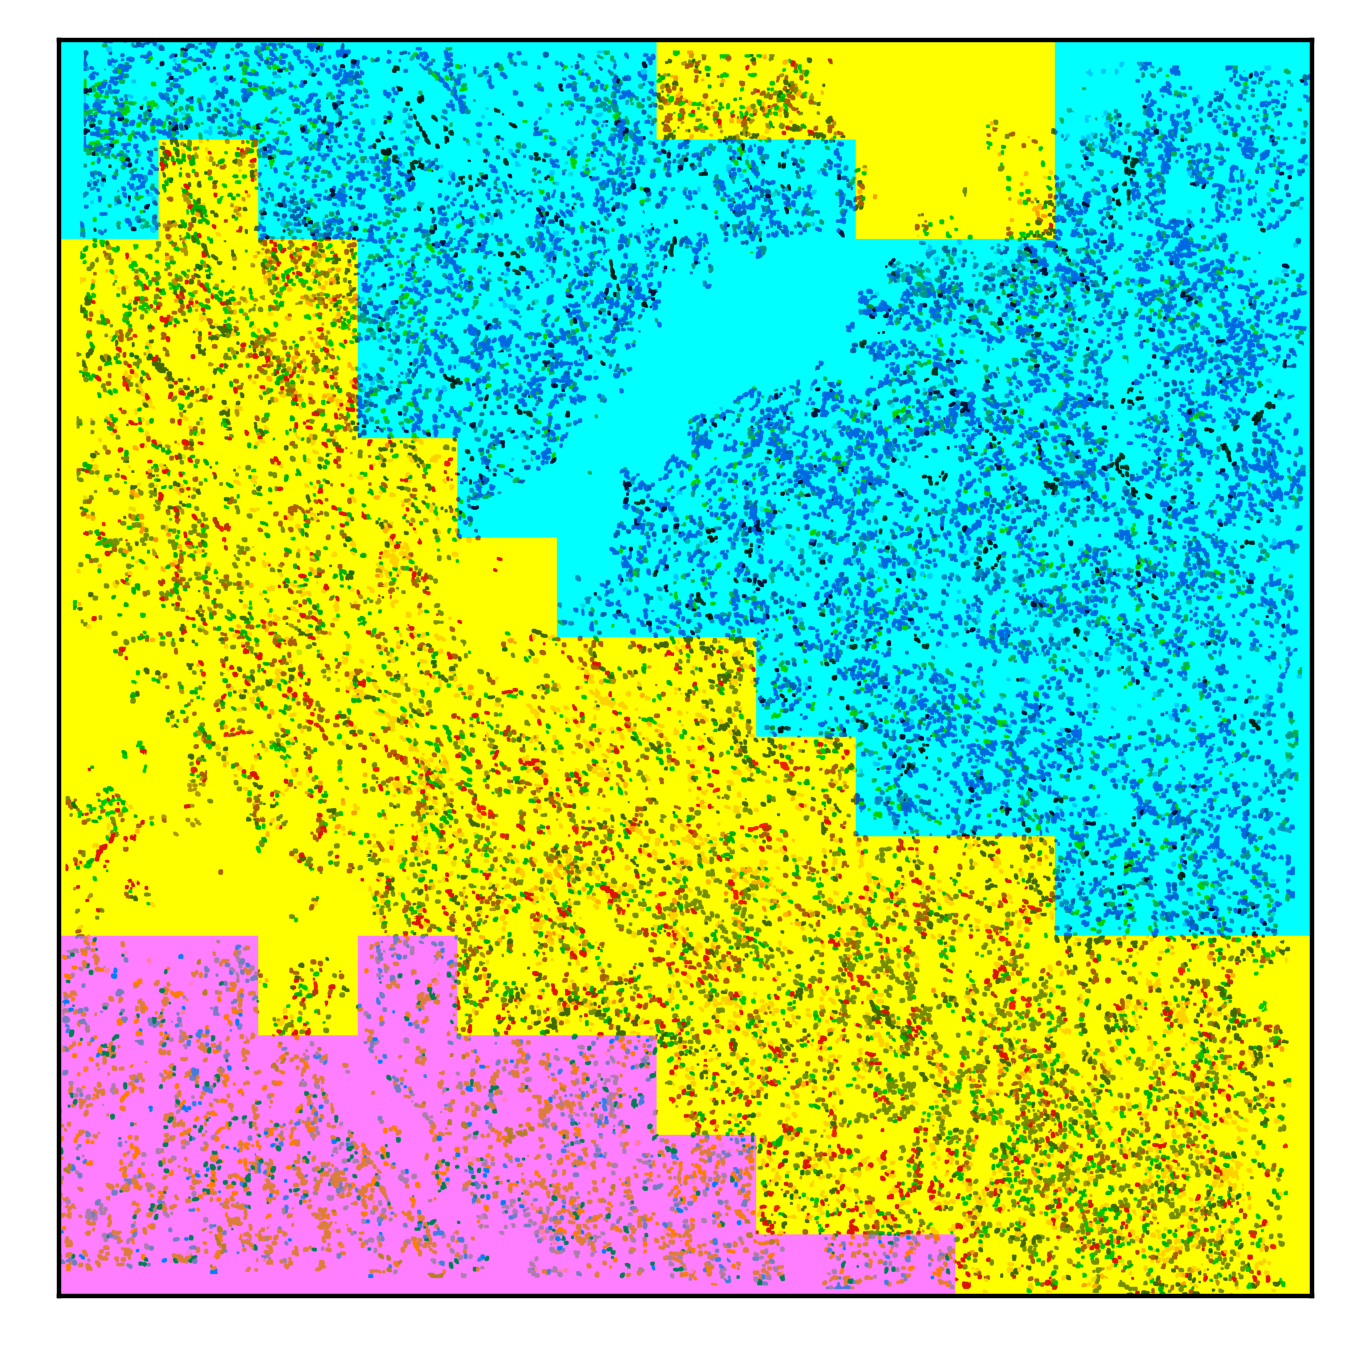

In [38]:
fig, ax = plt.subplots(1, 1,dpi=400)
#ax[0].imshow(padded_cellplot)
ax.imshow(refine_cluster_result[0:cellplot.shape[0],0:cellplot.shape[1]])
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('./Figure/spatial_clusters_cellplot.pdf',dpi=400)

## Draw bountry lines across three regions

In [ ]:
pure_anno_image = np.ndarray(padded_cellplot.shape[:2])
loop_count = 0
for curr_x in np.arange(0, pure_anno_image.shape[0], width):
    for curr_y in np.arange(0, pure_anno_image.shape[1], height):
        if refine_box_anno[loop_count] == '0':
            pure_anno_image[curr_x:curr_x+width,curr_y:curr_y+height] = 0
        elif refine_box_anno[loop_count] == '1':
            pure_anno_image[curr_x:curr_x+width,curr_y:curr_y+height] = 1
        elif refine_box_anno[loop_count] == '2':
            pure_anno_image[curr_x:curr_x+width,curr_y:curr_y+height] = 2
        sys.stdout.write('\r' + str(loop_count))
        sys.stdout.flush()
        loop_count += 1
pure_anno_image = pure_anno_image[0:seg.shape[0],0:seg.shape[1]]

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cellplot)
ax[1].imshow(pure_anno_image)
plt.tight_layout()

In [ ]:
from skimage.segmentation import find_boundaries
boundary = find_boundaries(pure_anno_image, connectivity=1, mode='inner')

In [47]:
boundary.shape

(15143, 15097)

In [48]:
boundary[boundary==True] = 1
boundary[boundary==False] = 0

In [49]:
# dilated
import cv2

kernel = np.ones((3, 3))
boundary_dilate = cv2.dilate(boundary.astype('uint8'), kernel, iterations=40)

In [54]:
#np.save('bountry_line_mask.npy',boundary_dilate)

In [50]:
#change MES-LIF [220, 20, 60] TO [235,   0, 155]
bountry_image = np.load('black_cellplot.npy')
R1 = bountry_image[...,0]
B1 = bountry_image[...,1]
G1 = bountry_image[...,2]
bountry_image[(R1==220)&(B1==20)&(G1==60)] = np.array([235,   0, 155])

# customize other color
# MES-COL1A1  [65, 105, 225] -> [42,42,250]
bountry_image[(R1==65)&(B1==105)&(G1==225)] = np.array([42, 42, 250])

In [51]:
bountry_image[boundary_dilate>0] = [255,255,255]

In [ ]:
#fig, ax = plt.subplots(1, 1)
#ax.imshow(bountry_image)
#ax.grid(False)
#ax.hlines(y=14000,xmin=11500,xmax=11500+400/0.16,colors='white')
#ax.set_xticks([])
#ax.set_yticks([])

MES_COL:[ 65, 105, 225]
AC: [254, 209,   0]
MES_LIF : [215,   0, 140]

### Add Zoom in bbox

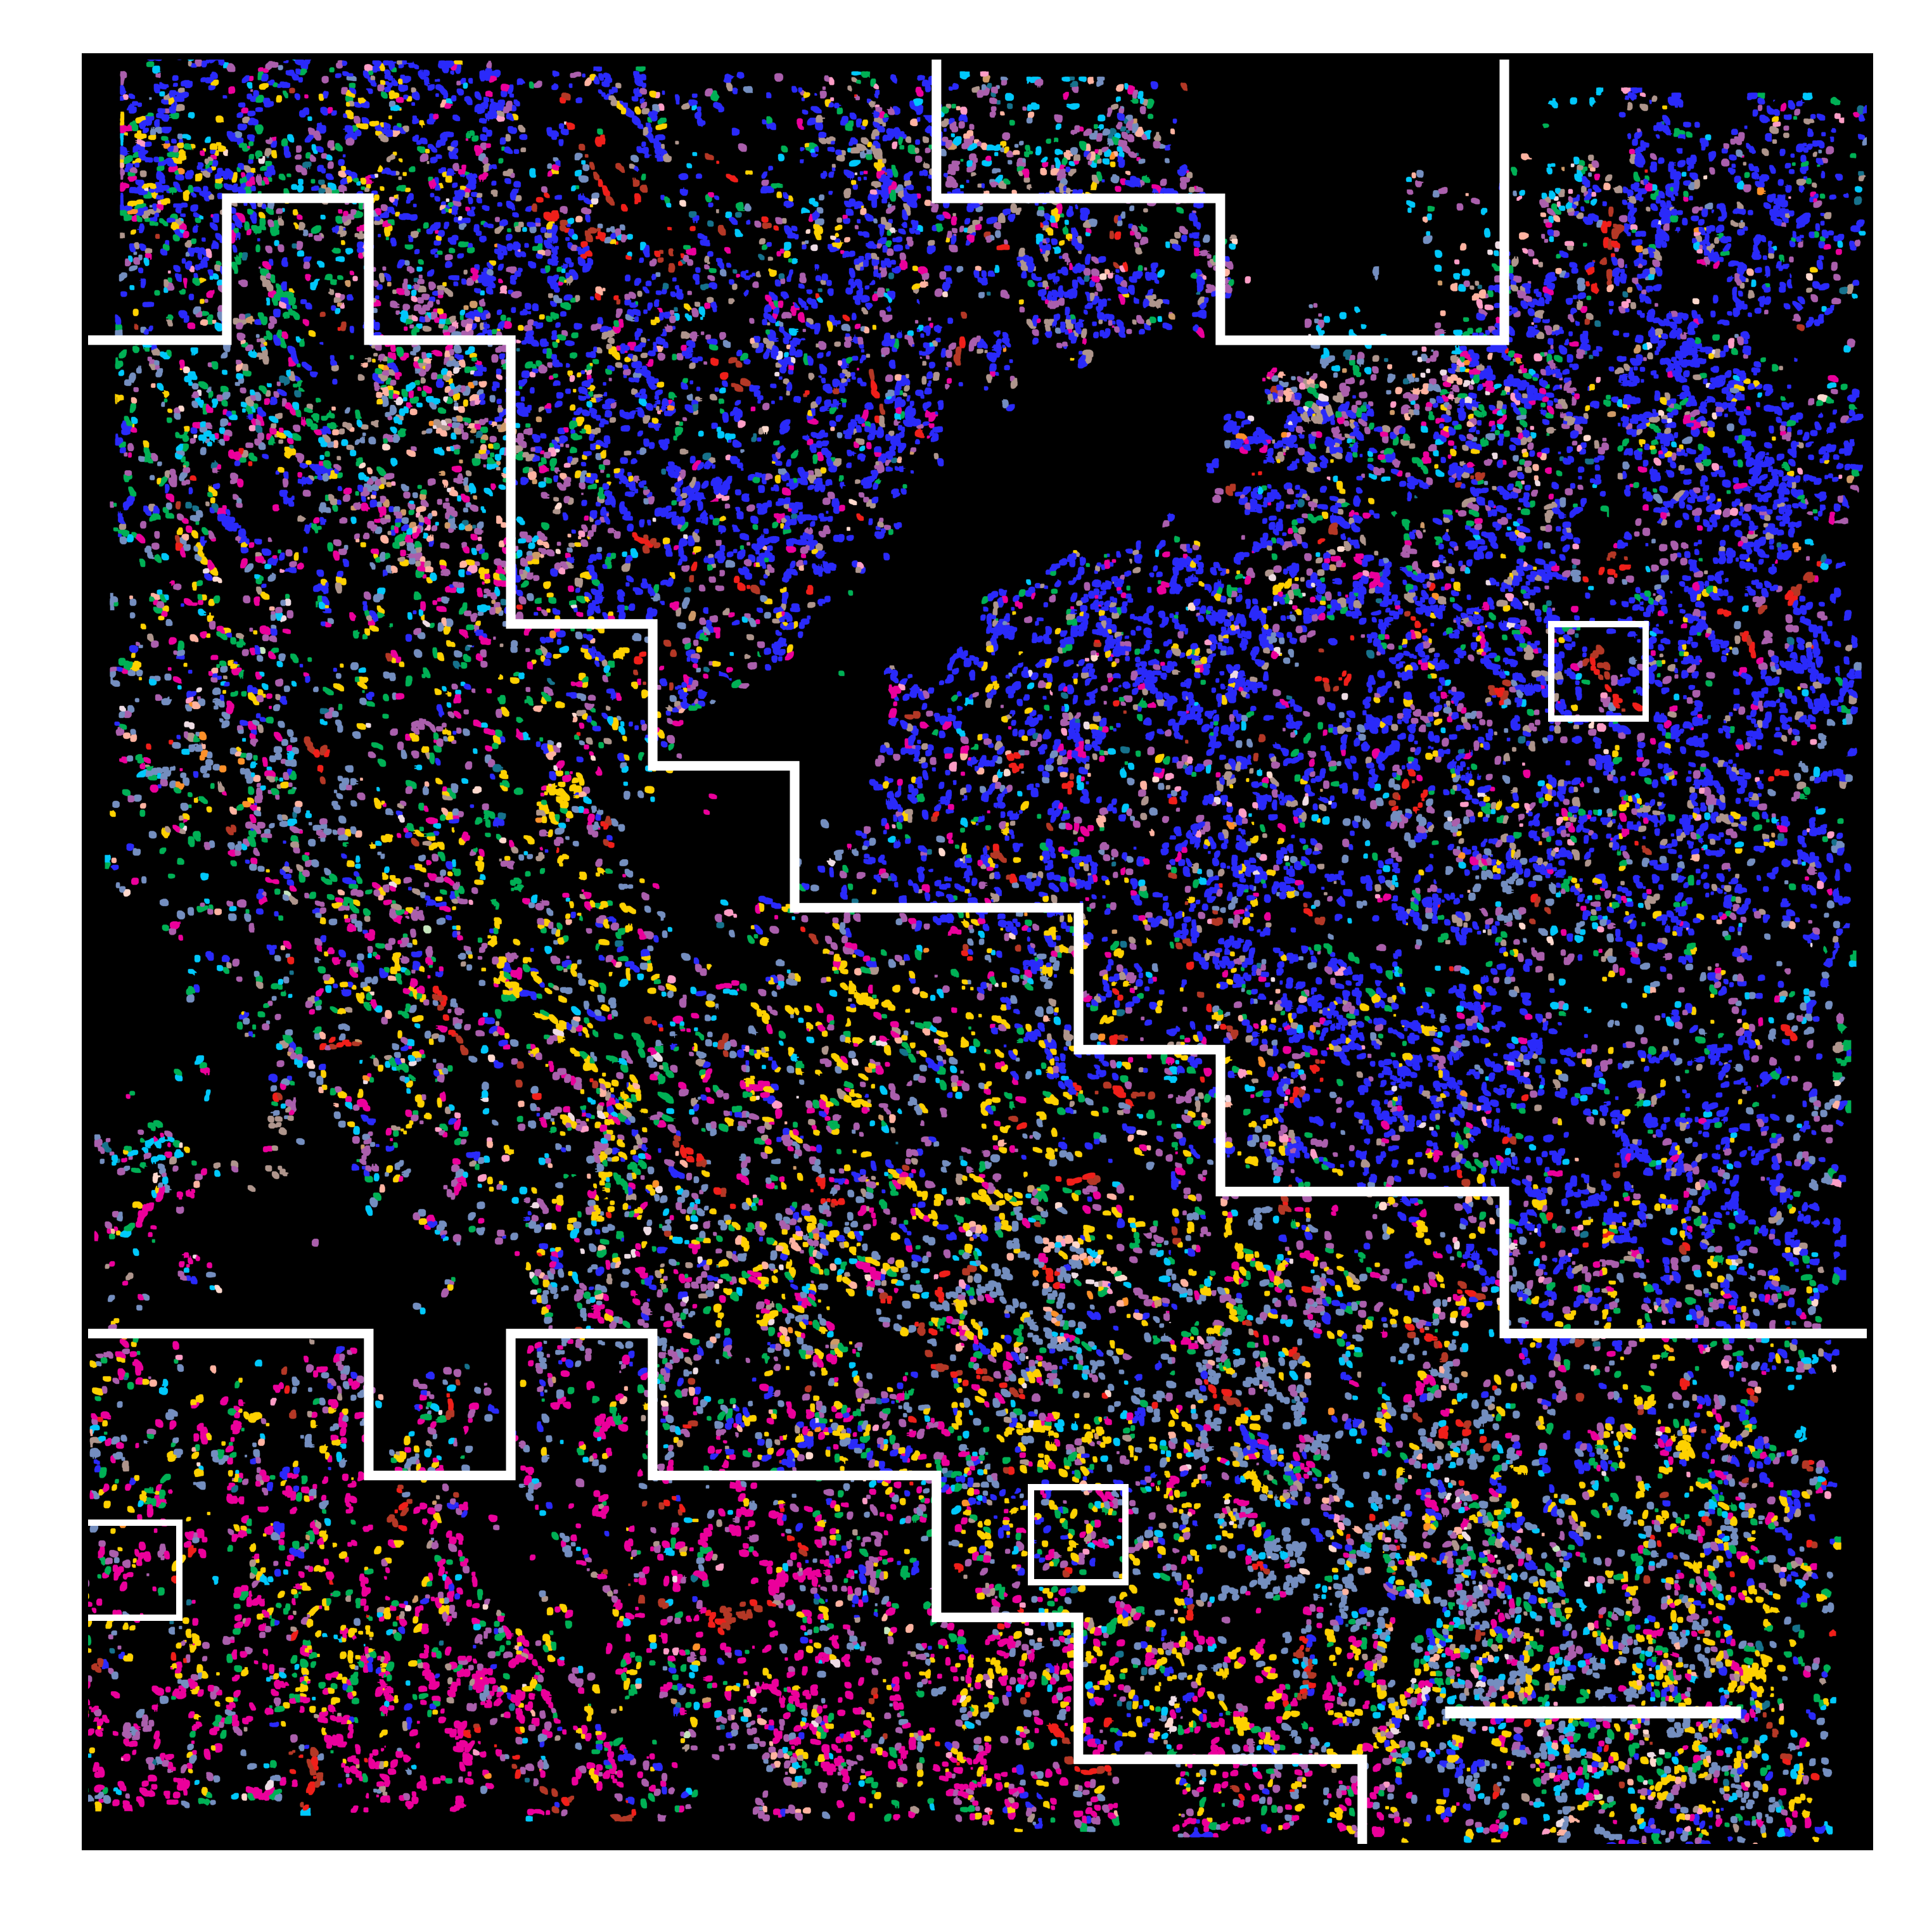

In [52]:
import matplotlib.patches as mpathes

top_xy = [800*15+400,800*6]
mid_xy = [800*10,4100+800*10]
bot_xy = [800*0,10000+800*3]

fig, ax = plt.subplots(1, 1, dpi=900)
ax.imshow(bountry_image)
ax.grid(False)
ax.hlines(y=14000,xmin=11500,xmax=11500+400/0.16,colors='white')
# top grid
rect1 = mpathes.Rectangle(top_xy,800,800,fc='none',ec='white',lw=0.8)
ax.add_patch(rect1)
# mid grid
rect2 = mpathes.Rectangle(mid_xy,800,800,fc='none',ec='white',lw=0.8)
ax.add_patch(rect2)
# bottom grid
rect3 = mpathes.Rectangle(bot_xy,800,800,fc='none',ec='white',lw=0.8)
ax.add_patch(rect3)

ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('./Figure/Figure_G.pdf',dpi=900)

### Add bountry lines

In [69]:
r_im = cellplot[:,:,0]
b_im = cellplot[:,:,1]
g_im = cellplot[:,:,2]

MES_COL_im = np.copy(cellplot)

MES_COL_im[(r_im==65)&(b_im==105)&(g_im==225)] = [255,7,0]
MES_COL_im[(r_im!=65)|(b_im!=105)|(g_im!=225)] = [0, 124, 33] # GREEN
MES_COL_im[(r_im==255)&(b_im==255)&(g_im==255)] = [255,255,255]
MES_COL_im[boundary_dilate>0] = [0,0,0]

# AC
AC_im = np.copy(cellplot)
AC_im[(r_im==254)&(b_im==209)&(g_im==0)] = [255,7,0]
AC_im[(r_im!=254)|(b_im!=209)|(g_im!=0)] = [0, 124, 33]#[56,158,40]
AC_im[(r_im==255)&(b_im==255)&(g_im==255)] = [255,255,255]
AC_im[boundary_dilate>0] = [0,0,0]

# MES-LIF
MES_LIF_im = np.copy(cellplot)
MES_LIF_im[(r_im==215)&(b_im==0)&(g_im==140)] = [255,7,0]
MES_LIF_im[(r_im!=215)|(b_im!=0)|(g_im!=140)] = [0, 124, 33]
MES_LIF_im[(r_im==255)&(b_im==255)&(g_im==255)] = [255,255,255]
MES_LIF_im[boundary_dilate>0] = [0,0,0]

In [ ]:
fig, ax = plt.subplots(1,1,dpi=600)
ax.imshow(MES_COL_im)
ax.hlines(y=14000,xmin=11500,xmax=11500+400/0.16,colors='black')
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('./Figure/H_MES_COL_zone.pdf',dpi=600)

In [ ]:
fig, ax = plt.subplots(1,1,dpi=600)
ax.imshow(AC_im)
ax.hlines(y=14000,xmin=11500,xmax=11500+400/0.16,colors='black')
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('./Figure/H_AC_zone.pdf',dpi=600)

In [ ]:
fig, ax = plt.subplots(1,1,dpi=600)
ax.imshow(MES_LIF_im)
ax.hlines(y=14000,xmin=11500,xmax=11500+400/0.16,colors='black')
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('./Figure/H_MES_LIF_zone.pdf',dpi=600)

## Zoom in

In [48]:
import cv2
from skimage.segmentation import find_boundaries
def add_bountry(tar_im, im, seg_im, curr_x, curr_y,  bountry_color, window_size=800,iterations=2):
    
    crop_im = np.copy(im[curr_x:curr_x+window_size,curr_y:curr_y+window_size,:])
    crop_seg = np.copy(seg_im[curr_x:curr_x+window_size,curr_y:curr_y+window_size,:])
    
    # get bountry
    # from skimage.segmentation import find_boundaries
    def make_outline_overlay(rgb_data, predictions):
        if len(predictions.shape) != 4:
            raise ValueError('Predictions must be 4D, got {}'.format(predictions.shape))

        if predictions.shape[0] > rgb_data.shape[0]:
            raise ValueError('Must supply an rgb image for each prediction')

        boundaries = np.zeros_like(rgb_data)
        overlay_data = np.copy(rgb_data)

        for img in range(predictions.shape[0]):
            boundary = find_boundaries(predictions[img, ..., 0], connectivity=1, mode='inner')
            boundaries[img, boundary > 0, :] = 1

        overlay_data[boundaries > 0] = 1

        return overlay_data
    
    crop_seg = np.squeeze(crop_seg)
    crop_seg = np.expand_dims(crop_seg, 0)
    crop_seg = np.expand_dims(crop_seg, -1)
    white = np.full(crop_seg.shape, 255)
    mask = make_outline_overlay(white, crop_seg)
    
    #import cv2
    if iterations > 0:
        kernel = np.ones((2, 2))
        img_dilate = cv2.erode(np.squeeze(mask).astype('uint8'), kernel, iterations=iterations)
    elif iterations < 0:
        kernel = np.ones((2, 2))
        img_dilate = cv2.dilate(np.squeeze(mask).astype('uint8'), kernel, iterations=-iterations)
    else:
        mask = np.squeeze(mask)
        img_dilate = mask
    tar_copy = np.copy(tar_im)  
    tar_copy[np.where(img_dilate==1)] = bountry_color

    return tar_copy

In [49]:
white_cellplot = np.copy(cellplot)
temp = cellplot[:,:,0] + cellplot[:,:,1] + cellplot[:,:,2]
white_cellplot[temp==0] = [255,255,255]

In [50]:
seg = np.squeeze(seg)
seg = np.expand_dims(seg, -1)

In [51]:
top_im = np.copy(white_cellplot[800*6:800*7,800*15+400:800*16+400])
r_top_im = white_cellplot[800*6:800*7,800*15+400:800*16+400,0]
g_top_im = white_cellplot[800*6:800*7,800*15+400:800*16+400,1]
b_top_im = white_cellplot[800*6:800*7,800*15+400:800*16+400,2]

In [52]:
top_im[(r_top_im!=255)|(g_top_im!=255)|(b_top_im!=255)] = [164, 226, 198]
top_im[(r_top_im==65)&(g_top_im==105)&(b_top_im==225)] = [42,42,250] # MES-COLA1A CHANGED color!
top_im[(r_top_im==220)&(g_top_im==20)&(b_top_im==60)] =  [215, 0, 140]   # MES-LIF CHANGED color!
top_im[(r_top_im==240)&(g_top_im==31)&(b_top_im==26)] = [240,  31,  26]    # 15
top_im[(r_top_im==180)&(g_top_im==56)&(b_top_im==38)] = [180,  56,  38]    # 18  
top_im[(r_top_im==254)&(g_top_im==209)&(b_top_im==0)] = [254,209,0]        # AC
top_im[(r_top_im==0)&(g_top_im==176)&(b_top_im==85)] = [0, 176,  85]      # PN  

In [53]:
top_im_bountry = add_bountry(top_im, white_cellplot, seg, 
                             800*6, 800*15+400, 
                             bountry_color=[40,40,40],
                             iterations=2)

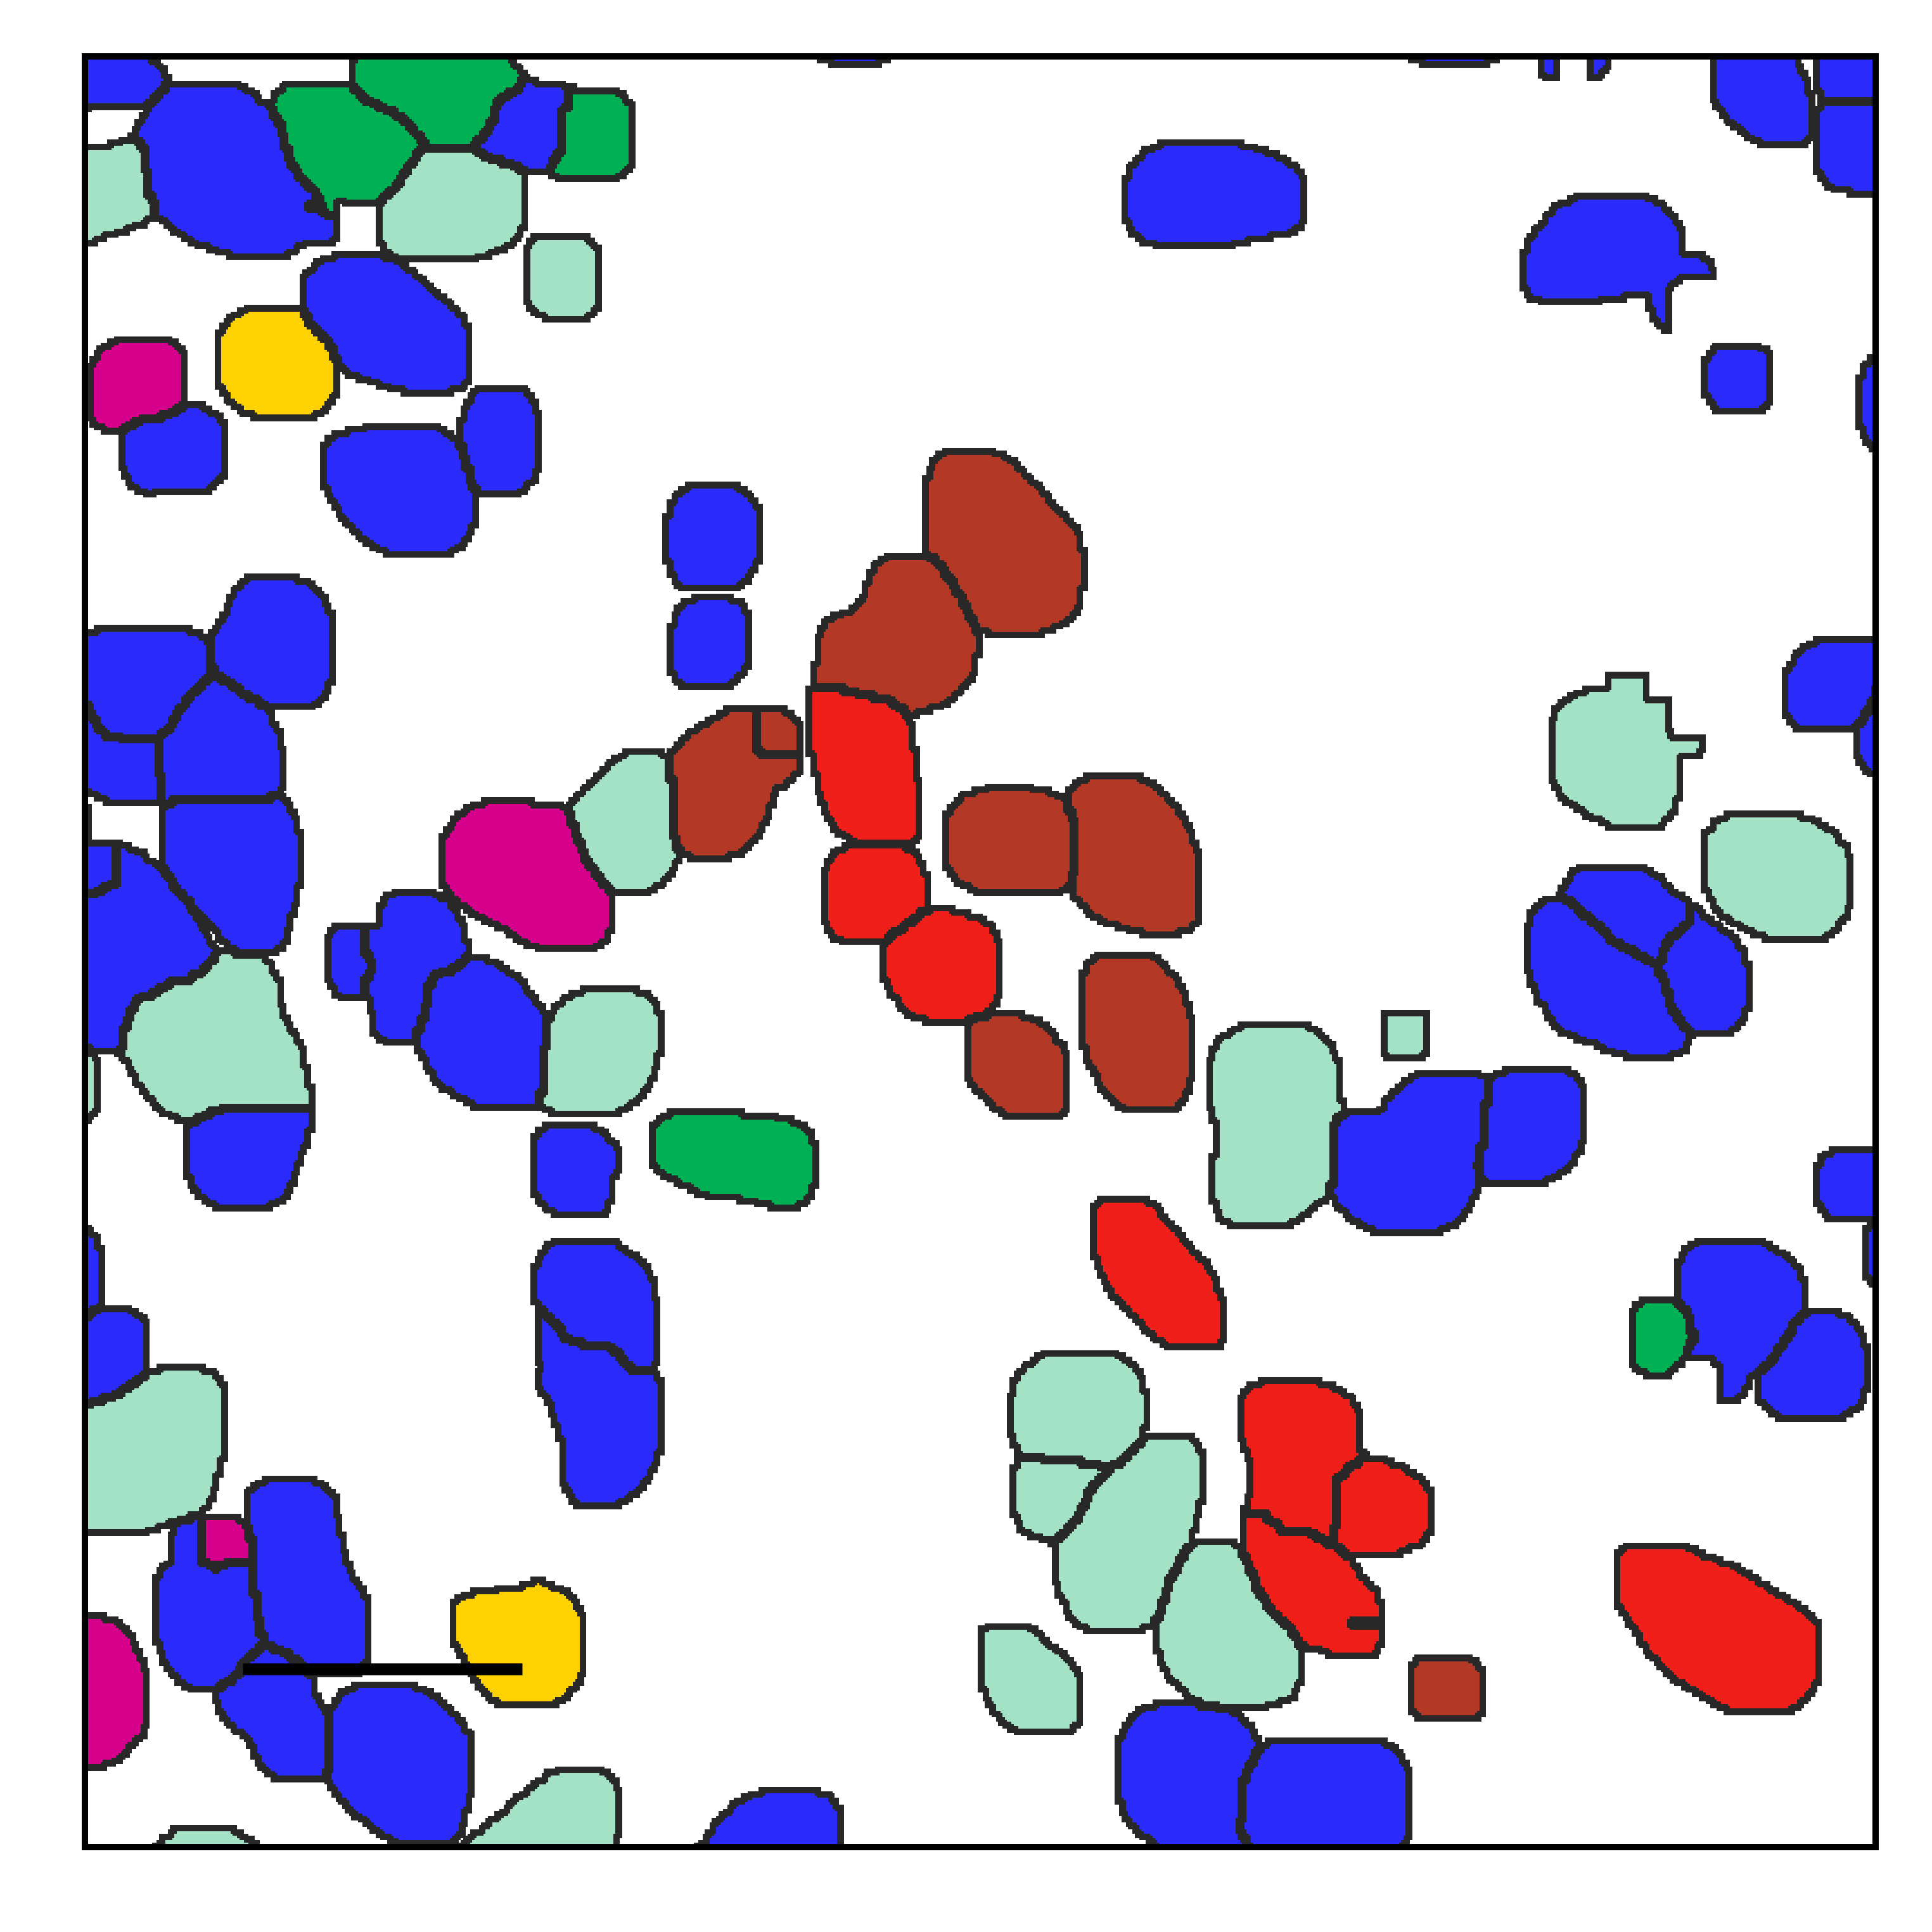

In [54]:
plt.figure(dpi=900)
plt.imshow(top_im_bountry)
plt.hlines(y=720,xmin=70,xmax=70+20/0.16,colors='black') # 20um
plt.xticks([])
plt.yticks([])
#plt.savefig('./Figure/I_zoom_in_top.pdf',dpi=900)